# Предсказание тяжести ДТП в Москве и Московской области: визуализации

In [1]:
import calendar
import folium

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter('ignore')

sns.set(style="darkgrid", palette='flare')

In [3]:
df = pd.read_csv('dtp_msc.csv')
print(f'Объектов изначально: {df.shape[0]}')
print(f'Признаков изначально: {df.shape[1]}')

Объектов изначально: 88566
Признаков изначально: 58


In [4]:
df.head()

Unnamed: 0              RTA type        date         traffic changes info  \
0           0          Столкновение  31.01.2015  Режим движения не изменялся   
1           1  Наезд на препятствие  31.01.2015  Режим движения не изменялся   
2           2          Столкновение  31.01.2015  Режим движения не изменялся   
3           3          Столкновение  31.01.2015  Движение частично перекрыто   
4           4     Наезд на пешехода  31.01.2015  Режим движения не изменялся   

     COORD_L    COORD_W road significance factors influenced traffic  \
0  37.274722  55.739444        Не указано       Сведения отсутствуют   
1  37.701389  55.734444        Не указано       Сведения отсутствуют   
2  37.630000  55.801944        Не указано       Сведения отсутствуют   
3  36.933056  55.464444       Иная дорога       Сведения отсутствуют   
4  37.610833  55.770000        Не указано       Сведения отсутствуют   

                                 street significance  RTA road km  ...  \
0                               Магистральные дороги          0.0  ...   
1             Магистральные улицы районного значения         31.0  ...   
2  Улицы и дороги местного значения в жилой застр...          0.0  ...   
3                                             Вне НП          0.0  ...   
4        Магистральные улицы общегородского значения          0.0  ...   

   any cyclists any concomitant traffic violations  \
0             0                                  0   
1             0                                  0   
2             0                                  1   
3             0                                  0   
4             0                                  0   

  any injuries without safety belt any child restraints  \
0                                0                    0   
1                                0                    0   
2                                0                    0   
3                                0                    0   
4                                0                    0   

   number of guilty objects  \
0                         1   
1                         1   
2                         1   
3                         1   
4                         1   

                          fatal traffic violation(s)  \
0  {'Несоответствие скорости конкретным условиям ...   
1  {'Несоответствие скорости конкретным условиям ...   
2               {'Несоблюдение очередности проезда'}   
3           {'Нарушение требований дорожных знаков'}   
4  {'Нарушение правил проезда пешеходного перехода'}   

  number of fatal traffic violations  \
0                                  1   
1                                  1   
2                                  1   
3                                  1   
4                                  1   

                                         bodily harm  \
0  {'Раненый, находящийся (находившийся)  на амбу...   
1  {'Раненый, находящийся (находившийся)  на амбу...   
2  {'Раненый, находящийся (находившийся)  на амбу...   
3  {'Раненый, находящийся (находившийся)  на амбу...   
4  {'Раненый, находящийся (находившийся)  на амбу...   

   guilty drivers average experience  drivers average experience  
0                                4.0                         4.0  
1                                0.0                         0.0  
2                               14.0                         8.5  
3                                1.0                         8.5  
4                               12.0                        12.0  

[5 rows x 58 columns]

In [5]:
df.columns

Index(['Unnamed: 0', 'RTA type', 'date', 'traffic changes info', 'COORD_L',
       'COORD_W', 'road significance', 'factors influenced traffic',
       'street significance', 'RTA road km', 'RTA road m',
       'road network maintenance defects', 'RTA-adjacent road objects',
       'lighting', 's_dtp', 'road surface condition', 'RTA site road objects',
       'weather', 'RTA vehicle number', 'RTA participants number',
       'RTA number', 'number of deaths', 'number of wounded', 'RTA time',
       'any TV technical failures', 'any non-private vehicles',
       'any russian vehicles', 'any vehicles older than 1990',
       'any vehicles older than 2000', 'any vehicles older than 2010',
       'any white vehicles', 'any black vehicles', 'any colored vehicles',
       'any front-wheel-drive vehicles', 'any rear-wheel-drive vehicles',
       'any four-wheel-drive vehicles', 'any A-class vehicles',
       'any B-class vehicles', 'any C-class vehicles', 'any D-class vehicles',
       'any E-

**Новые признаки:**
- день недели
- месяц
- год
- час в сутках
- наш таргет

In [6]:
year = df['date'].astype(str).str[6:10]
hour = df['RTA time'].astype(str).str[:2]
weekday = df.astype({'date' : 'datetime64[ns]'})['date'].apply(lambda x: calendar.day_name[x.weekday()])
month = df.astype({'date' : 'datetime64[ns]'})['date'].apply(lambda x: calendar.month_name[x.month])
target = (df['number of deaths'] != 0).astype('int64')
df.insert(58, 'weekday', weekday)
df.insert(59, 'month', month)
df.insert(60, 'year', year)
df.insert(61, 'hour', hour)
df.insert(62, 'target', target)

In [7]:

categorical = ['RTA type', 
               'road significance', 
               'factors influenced traffic',
               'fatal traffic violation(s)',
               'traffic changes info',
               'street significance',
               'road network maintenance defects', 
               'RTA-adjacent road objects',
               'lighting', 
               'road surface condition', 
               'RTA site road objects',
               'weather',
               'weekday', 
               'month', 
               'year', 
               'hour']
numerical = ['RTA participants number',
             'number of guilty objects',
             'number of wounded',
             'number of fatal traffic violations', 
             'guilty drivers average experience',
             'drivers average experience',
             'RTA road m']
bol = ['any TV technical failures', 
       'any non-private vehicles',
       'any russian vehicles', 
       'any vehicles older than 1990',
       'any vehicles older than 2000', 
       'any vehicles older than 2010',
       'any white vehicles', 
       'any black vehicles', 
       'any colored vehicles',
       'any front-wheel-drive vehicles', 
       'any rear-wheel-drive vehicles',
       'any four-wheel-drive vehicles', 
       'any A-class vehicles',
       'any B-class vehicles', 
       'any C-class vehicles', 
       'any D-class vehicles',
       'any E-class vehicles', 
       'any S-class vehicles', 
       'any non-car vehicles',
       'any drunk passengers', 
       'any drunk drivers', 
       'any female drivers',
       'any escaped participants', 
       'any pedestrians', 
       'any cyclists',
       'any concomitant traffic violations',
       'any injuries without safety belt', 
       'any child restraints']

### Исследование признаков: выбросы, корреляция

**Выбросы в опыте водителей**

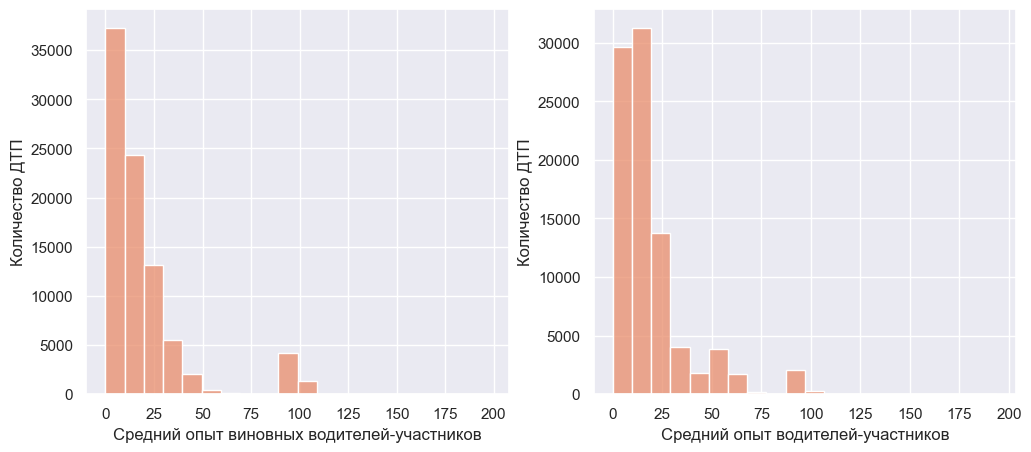

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(df['guilty drivers average experience'], bins=20)
plt.xlabel('Средний опыт виновных водителей-участников')
plt.ylabel('Количество ДТП');

plt.subplot(1, 2, 2)
sns.histplot(df['drivers average experience'], bins=20)
plt.xlabel('Средний опыт водителей-участников')
plt.ylabel('Количество ДТП');

In [9]:
df = df[df['guilty drivers average experience'] <= 60]
df = df[df['drivers average experience'] <= 60]
print(f'Объектов после обработки: {df.shape[0]}')

Объектов после обработки: 82202


**Корреляция числовых признаков друг с другом**

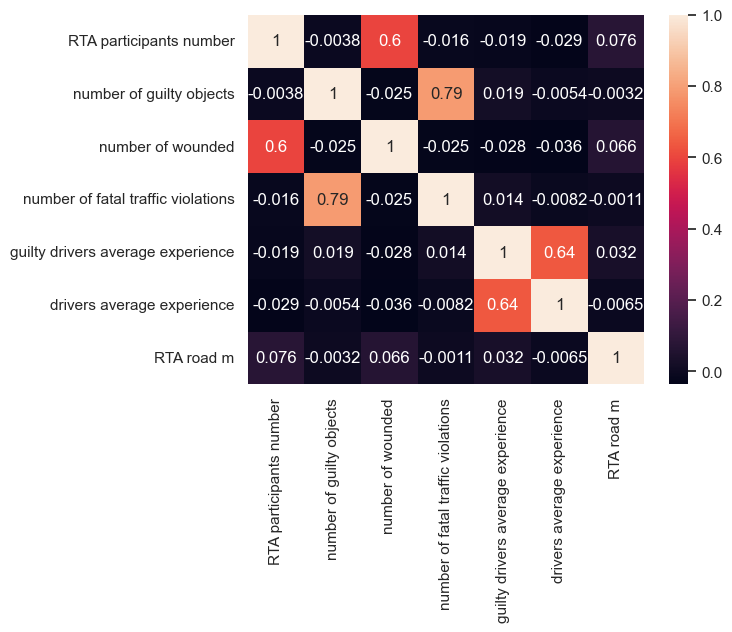

In [44]:
sns.heatmap(df[numerical].corr(), annot=True);

### Географическое распределение ДТП

In [11]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    location = (data[latitude_column].astype('float').mean(), data[longitude_column].astype('float').mean())
    m = folium.Map(location=location)
    # colors = {'2015' : 'blue',
    #           '2016' : 'red',
    #           '2017' : 'yellow',
    #           '2018' : 'pink',
    #           '2019' : 'green',
    #           '2020' : 'black',
    #           '2021' : 'orange',
    #           '2022' : 'blueviolet',
    #           '2023' : 'cyan',
    #           '2024' : 'lime'}

    for _, row in data.iterrows():
        folium.Circle(
            radius=10,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [12]:
df = df[df['COORD_L'] != '.']
show_circles_on_map(df.sample(5000), "COORD_W", "COORD_L", "blue")

**Вывод: несмотря на то, что высокая аварийность МКАД и крупных шоссе согласовывается с базовой логикой, на графике можно найти некоторые точки, которые по менее очевидным причинам более аварийные, чем другие**

### Зависимость количества ДТП и раненых/погибших от различных признаков

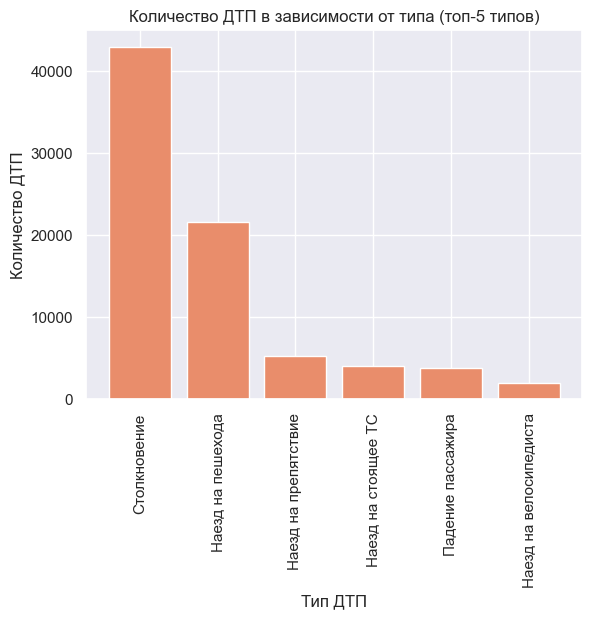

In [13]:
plt.bar(df['RTA type'].value_counts()[:6].index.values, df['RTA type'].value_counts()[:6].values)
plt.xlabel('Тип ДТП')
plt.ylabel('Количество ДТП')
plt.xticks(rotation=90)
plt.title('Количество ДТП в зависимости от типа (топ-5 типов)');

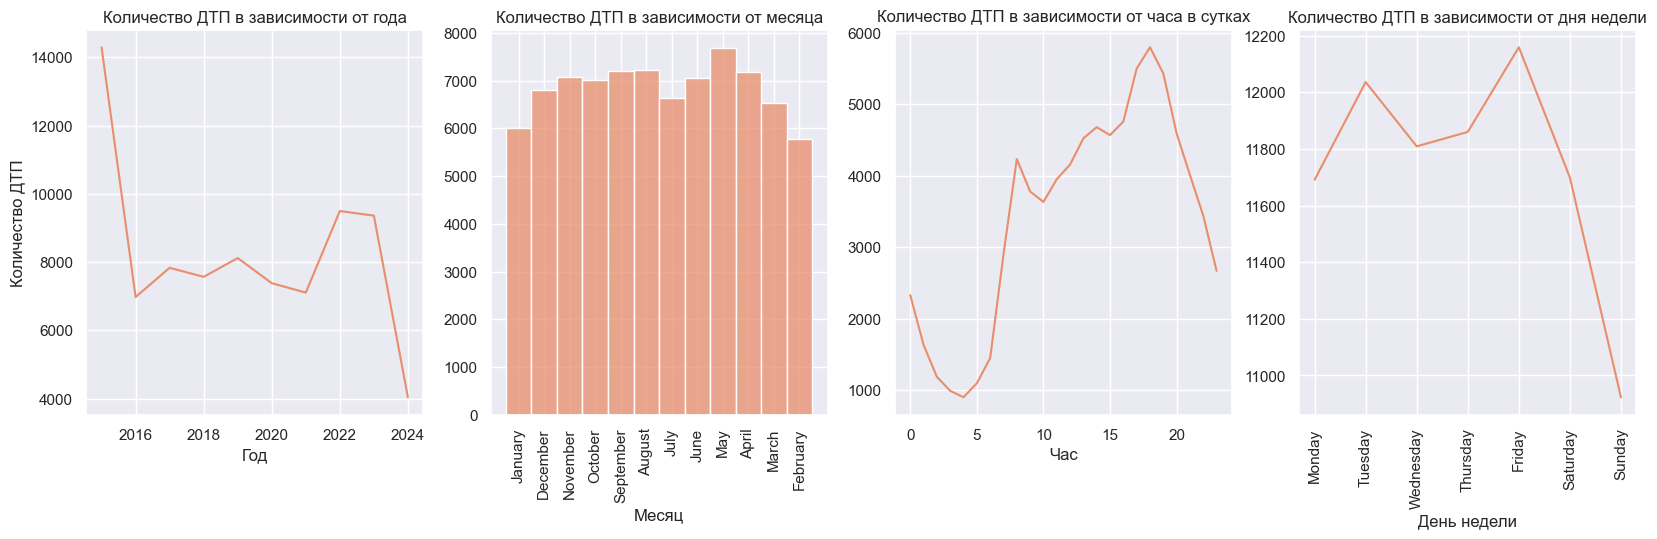

In [14]:
plt.figure(figsize=(20,5))

plt.subplot(1, 4, 1)
sns.lineplot(df['year'].astype('int64').value_counts())
plt.ylabel('Количество ДТП')
plt.xlabel('Год')
plt.title('Количество ДТП в зависимости от года');

plt.subplot(1, 4, 2)
sns.histplot(df['month'])
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('Месяц')
plt.title('Количество ДТП в зависимости от месяца');

plt.subplot(1, 4, 3)
sns.lineplot(df['hour'].astype('int64').value_counts())
plt.ylabel('')
plt.xlabel('Час')
plt.title('Количество ДТП в зависимости от часа в сутках');

plt.subplot(1, 4, 4)
sns.lineplot(df['weekday'].value_counts().sort_index(key=lambda x: x.map(list(calendar.day_name).index)))
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('День недели')
plt.title('Количество ДТП в зависимости от дня недели');

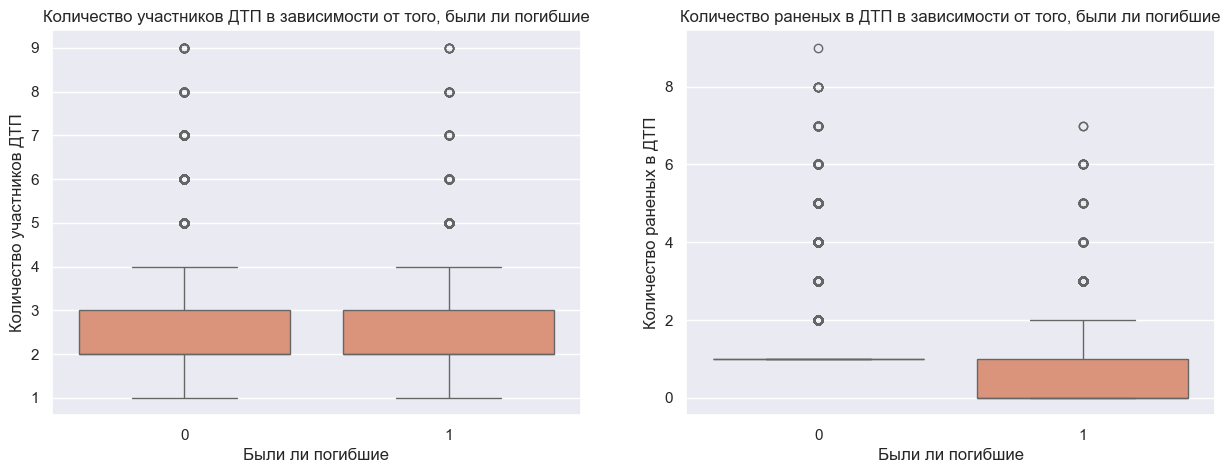

In [15]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['target'], y=df['RTA participants number'])
plt.ylabel('Количество участников ДТП')
plt.xlabel('Были ли погибшие')
plt.title('Количество участников ДТП в зависимости от того, были ли погибшие');

plt.subplot(1, 2, 2)
sns.boxplot(x=df['target'], y=df['number of wounded'])
plt.ylabel('Количество раненых в ДТП')
plt.xlabel('Были ли погибшие')
plt.title('Количество раненых в ДТП в зависимости от того, были ли погибшие');

**Вывод:** 

а) распределение количества ДТП в зависимости от часа/дня/месяца имеет форму, сильно коррелирующую с плотностью автомобильного движени в принципе (неожиданный факт: если построить такие графики для спроса на такси, нетрудно будет заметить что-то очень похожее), 

б) в группах ДТП с погибшими и без не наблюдается различий в количестве участников

### Баланс таргета в разных категориях

**Тип ДТП**

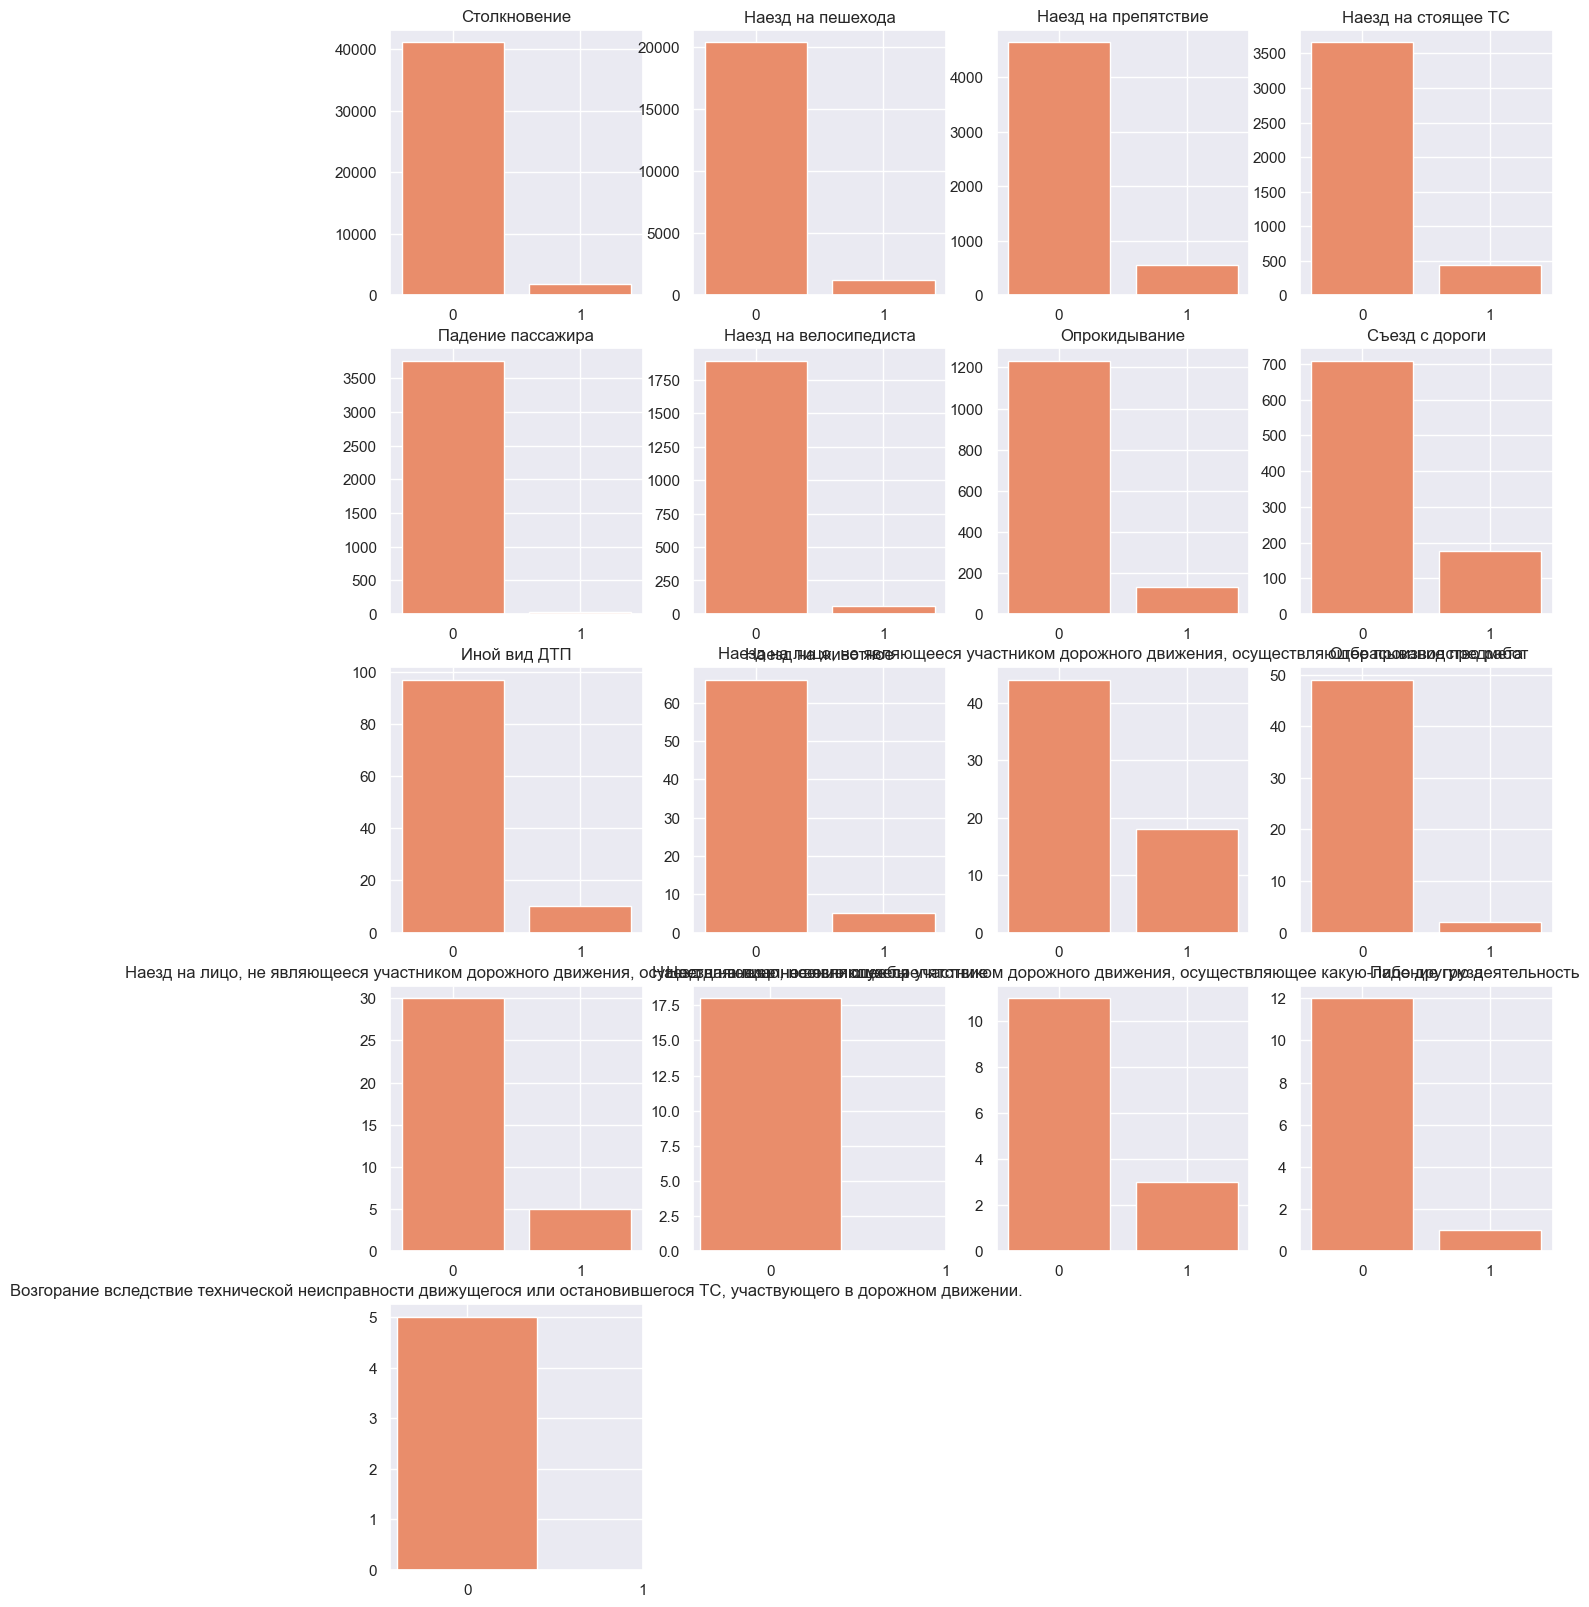

In [38]:
sp = df['RTA type'].value_counts().index.values
plt.figure(figsize=(15, 20))
for i in range(len(sp)):
    cnt = df[df['RTA type'] == sp[i]]['target'].value_counts()
    plt.subplot(5, 4, i + 1)
    plt.bar(cnt.index.values, cnt.values)
    plt.title(sp[i])
    plt.xticks(ticks=[0,1])

**День недели**

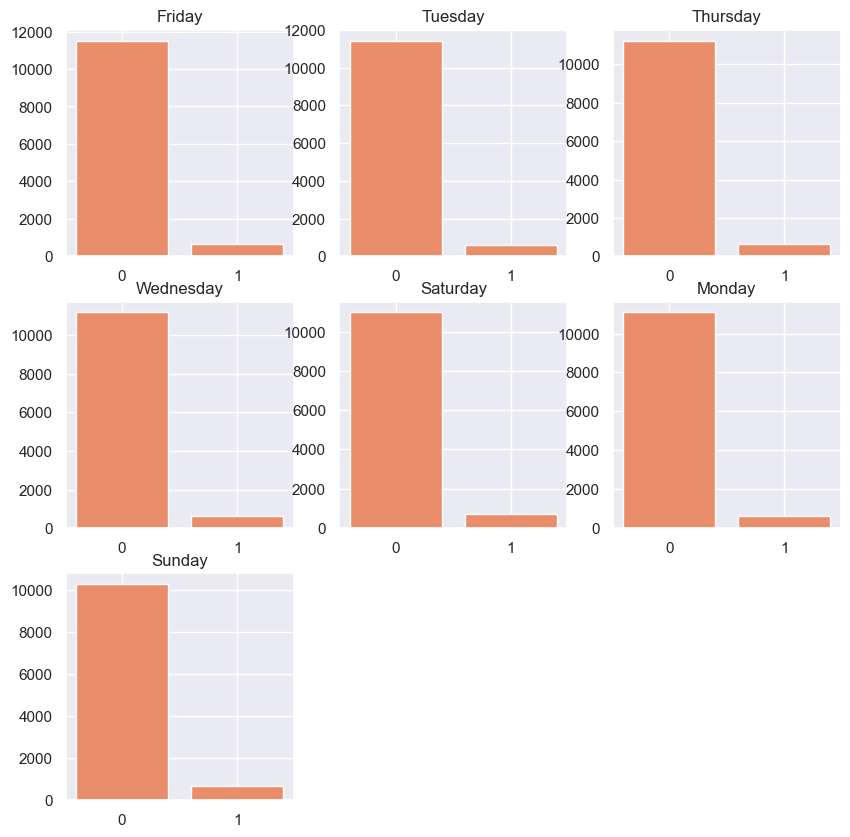

In [42]:
sp = df['weekday'].value_counts().index.values
plt.figure(figsize=(10, 10))
for i in range(len(sp)):
    cnt = df[df['weekday'] == sp[i]]['target'].value_counts()
    plt.subplot(3, 3, i + 1)
    plt.bar(cnt.index.values, cnt.values)
    plt.title(sp[i])
    plt.xticks(ticks=[0,1])

**Месяц**

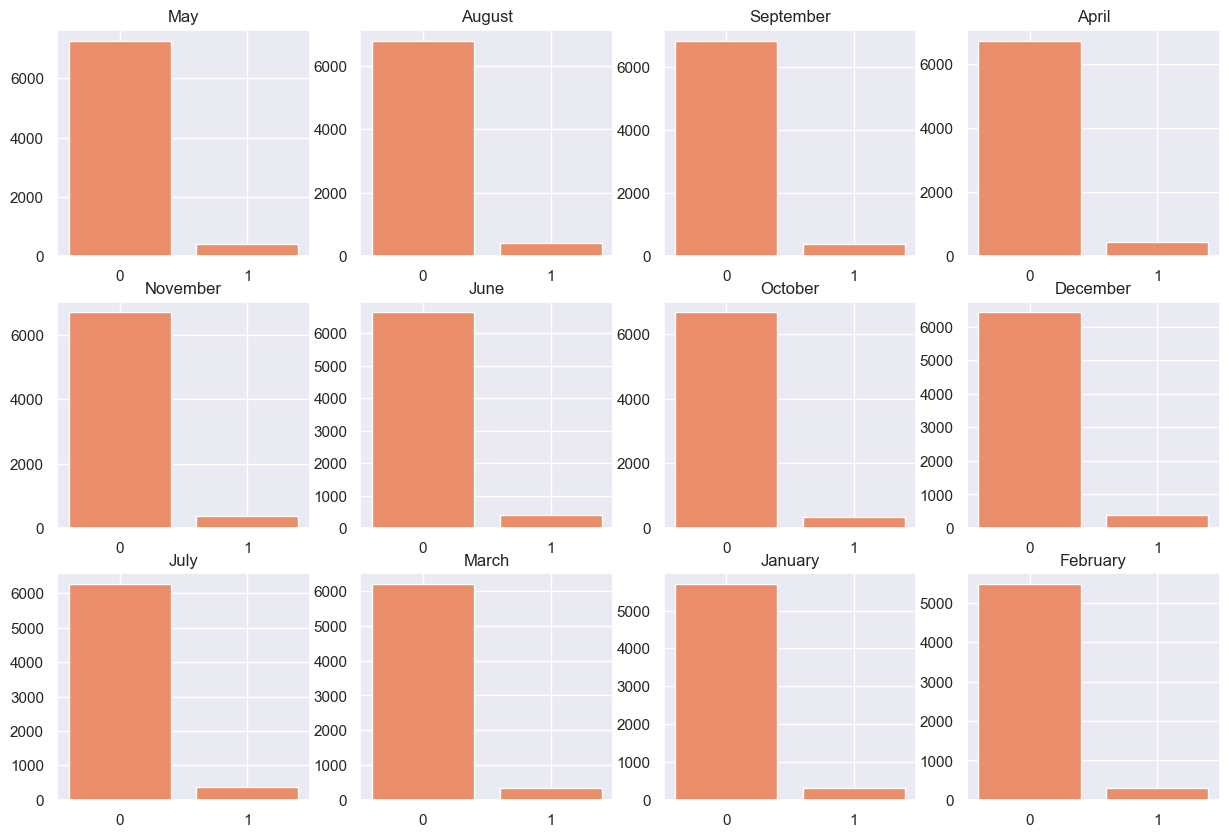

In [49]:
sp = df['month'].value_counts().index.values
plt.figure(figsize=(15, 10))
for i in range(len(sp)):
    cnt = df[df['month'] == sp[i]]['target'].value_counts()
    plt.subplot(3, 4, i + 1)
    plt.bar(cnt.index.values, cnt.values)
    plt.title(sp[i])
    plt.xticks(ticks=[0,1])

**Погодные условия**

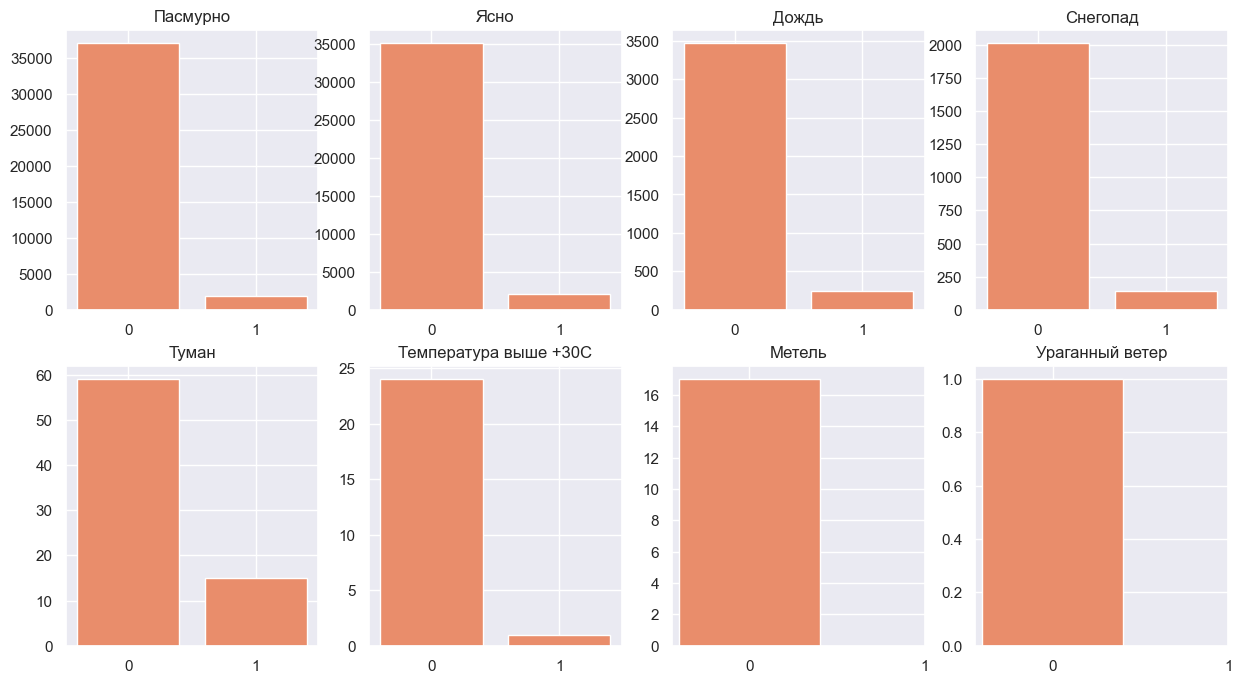

In [59]:
sp = df['weather'].value_counts().index.values
plt.figure(figsize=(15, 8))
for i in range(len(sp)):
    cnt = df[df['weather'] == sp[i]]['target'].value_counts()
    plt.subplot(2, 4, i + 1)
    plt.bar(cnt.index.values, cnt.values)
    plt.title(sp[i])
    plt.xticks(ticks=[0,1])

**Освещение**

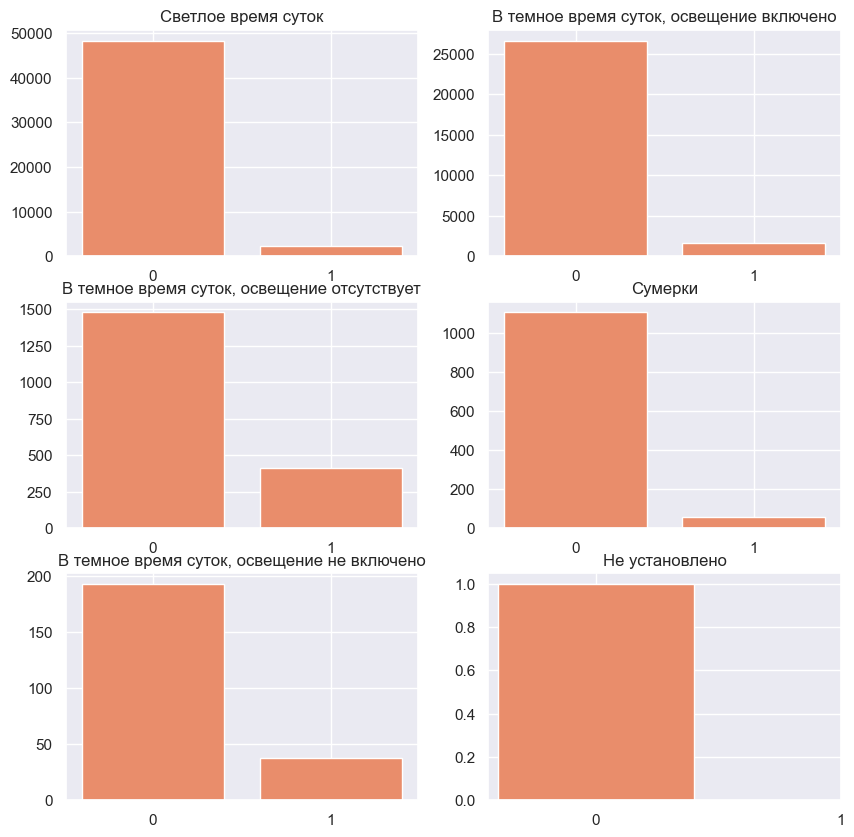

In [69]:
sp = df['lighting'].value_counts().index.values
plt.figure(figsize=(10, 10))
for i in range(len(sp)):
    cnt = df[df['lighting'] == sp[i]]['target'].value_counts()
    plt.subplot(3, 2, i + 1)
    plt.bar(cnt.index.values, cnt.values)
    plt.title(sp[i])
    plt.xticks(ticks=[0,1])

**Вывод - таргет распределен примерно одинаково во всех крупных группах, не считая двух типов ДТП и погодных условий, где не было погибших**